In [2]:
from torch.utils.data import TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import InformerConfig, InformerModel, InformerForPrediction, AutoformerForPrediction, AutoformerConfig, PatchTSTConfig, PatchTSTForPrediction
from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

/Users/apple/anaconda3/envs/timeseries/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/67/bhjq37955y5_sr34fd9gznsm0000gn/T/ipykernel_56989/1619103076.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Initializing an Informer configuration with 12 time steps for prediction
configuration = PatchTSTConfig(prediction_length=1, context_length=24, num_time_features=6, lags_sequence = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
)

model = PatchTSTForPrediction(configuration)

In [4]:
configuration.context_length

24

In [5]:
configuration.prediction_length

1

In [6]:
print(configuration)

PatchTSTConfig {
  "activation_function": "gelu",
  "attention_dropout": 0.0,
  "bias": true,
  "channel_attention": false,
  "channel_consistent_masking": false,
  "context_length": 24,
  "d_model": 128,
  "distribution_output": "student_t",
  "do_mask_input": null,
  "dropout": 0.0,
  "ff_dropout": 0.0,
  "ffn_dim": 512,
  "head_dropout": 0.0,
  "init_std": 0.02,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24
  ],
  "loss": "mse",
  "mask_type": "random",
  "mask_value": 0,
  "model_type": "patchtst",
  "norm_eps": 1e-05,
  "norm_type": "batchnorm",
  "num_attention_heads": 4,
  "num_forecast_mask_patches": [
    2
  ],
  "num_hidden_layers": 3,
  "num_input_channels": 1,
  "num_parallel_samples": 100,
  "num_targets": 1,
  "num_time_features": 6,
  "output_range": null,
  "patch_length": 1,
  "patch_stride": 1,
  "path_dropout": 

In [7]:
device = torch.device("cpu")
device

device(type='cpu')

In [8]:
data = pd.read_csv("full.csv")
target_column = 'PRICE'  # Replace with the actual target column name

In [9]:
data.keys()

Index(['TIME', 'PRICE'], dtype='object')

In [10]:
print(data)

                  TIME  PRICE
0     01-01-2017 00:00  22.11
1     01-01-2017 01:00  21.30
2     01-01-2017 02:00  21.00
3     01-01-2017 03:00  20.56
4     01-01-2017 04:00  20.62
...                ...    ...
8755  31-12-2017 19:00  51.80
8756  31-12-2017 20:00  46.64
8757  31-12-2017 21:00  41.45
8758  31-12-2017 22:00  41.49
8759  31-12-2017 23:00  31.42

[8760 rows x 2 columns]


In [11]:
# Convert 'TIME' column to datetime
data['TIME'] = pd.to_datetime(data['TIME'], dayfirst=True)

In [12]:
# Sort the data based on time
data = data.sort_values(by='TIME')

In [13]:
data.shape

(8760, 2)

In [14]:
def create_time_features(data):
    # Extract relevant temporal information
    data['hour'] = data['TIME'].dt.hour
    data['day_of_week'] = data['TIME'].dt.dayofweek
    data['month'] = data['TIME'].dt.month
    data['day'] = data['TIME'].dt.day
    data['year'] = data['TIME'].dt.year

    # Add is_weekend feature
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

    # Drop the original timestamp and PRICE columns
    data = data.drop(columns=['TIME', 'PRICE'])

    return data.values


# Assuming 'data' is your DataFrame
past_time_features = create_time_features(data)


In [15]:
past_time_features.shape

(8760, 6)

In [16]:
# Extract features and target
features = data['PRICE'].values

In [17]:
features.shape

(8760,)

In [18]:
# Split the data into train and validation sets
train, val = train_test_split(features, test_size=0.2, shuffle=False)

In [19]:
train.shape

(7008,)

In [20]:
val.shape

(1752,)

In [21]:
time_train = past_time_features[:train.shape[0]]
time_val = past_time_features[train.shape[0]:]

In [22]:
time_train

array([[   0,    6,    1,    1, 2017,    1],
       [   1,    6,    1,    1, 2017,    1],
       [   2,    6,    1,    1, 2017,    1],
       ...,
       [  21,    3,   10,   19, 2017,    0],
       [  22,    3,   10,   19, 2017,    0],
       [  23,    3,   10,   19, 2017,    0]])

In [23]:
time_train.shape

(7008, 6)

In [24]:
time_val.shape

(1752, 6)

In [25]:
class TimeSeriesDataset(Dataset):
    def __init__(self, price, time, sequence_length, context_length, prediction_length, target_column='PRICE'):
        self.price = price
        self.time = time
        self.sequence_length = sequence_length
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.target_column = target_column

    def __len__(self):
        return len(self.price) - self.sequence_length

    def __getitem__(self, idx):
        x = self.price[idx:idx + self.sequence_length]
        x = torch.tensor(np.asarray(x, dtype=np.float32), dtype=torch.float32)
        xt = self.time[idx:idx + self.sequence_length]
        xt = torch.tensor(np.asarray(xt, dtype=np.float32), dtype=torch.float32)
        #y = self.y[idx + self.sequence_length:idx + 2*self.sequence_length]
        y = self.price[idx + self.sequence_length]
        y = torch.tensor(np.asarray(y, dtype=np.float32), dtype = torch.float32)
        #yt = self.time[idx + self.sequence_length : idx + 2*self.sequence_length]
        yt = self.time[idx + self.sequence_length]
        yt = torch.tensor(np.asarray(yt, dtype=np.float32), dtype=torch.float32)
        #mask = torch.ones([24], dtype=torch.bool)
    
        # x = x.to(device)
        # t = t.to(device)
        # y = y.to(device)
        #mask = mask.to(device)
        return x, y, xt, yt
        

In [26]:
train_dataset = TimeSeriesDataset(train, time_train, sequence_length=24, context_length=configuration.context_length, prediction_length=configuration.prediction_length)
val_dataset = TimeSeriesDataset(val, time_val, sequence_length=24, context_length=configuration.context_length, prediction_length=configuration.prediction_length)

In [27]:
# DataLoader
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [28]:
model.to(device)

PatchTSTForPrediction(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=1, out_features=128, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-2): 3 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(128, eps=

In [29]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [30]:
configuration.prediction_length

1

In [31]:
configuration

PatchTSTConfig {
  "activation_function": "gelu",
  "attention_dropout": 0.0,
  "bias": true,
  "channel_attention": false,
  "channel_consistent_masking": false,
  "context_length": 24,
  "d_model": 128,
  "distribution_output": "student_t",
  "do_mask_input": null,
  "dropout": 0.0,
  "ff_dropout": 0.0,
  "ffn_dim": 512,
  "head_dropout": 0.0,
  "init_std": 0.02,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24
  ],
  "loss": "mse",
  "mask_type": "random",
  "mask_value": 0,
  "model_type": "patchtst",
  "norm_eps": 1e-05,
  "norm_type": "batchnorm",
  "num_attention_heads": 4,
  "num_forecast_mask_patches": [
    2
  ],
  "num_hidden_layers": 3,
  "num_input_channels": 1,
  "num_parallel_samples": 100,
  "num_targets": 1,
  "num_time_features": 6,
  "output_range": null,
  "patch_length": 1,
  "patch_stride": 1,
  "path_dropout": 

In [32]:
configuration.context_length + max(configuration.lags_sequence)

48

In [33]:
configuration

PatchTSTConfig {
  "activation_function": "gelu",
  "attention_dropout": 0.0,
  "bias": true,
  "channel_attention": false,
  "channel_consistent_masking": false,
  "context_length": 24,
  "d_model": 128,
  "distribution_output": "student_t",
  "do_mask_input": null,
  "dropout": 0.0,
  "ff_dropout": 0.0,
  "ffn_dim": 512,
  "head_dropout": 0.0,
  "init_std": 0.02,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24
  ],
  "loss": "mse",
  "mask_type": "random",
  "mask_value": 0,
  "model_type": "patchtst",
  "norm_eps": 1e-05,
  "norm_type": "batchnorm",
  "num_attention_heads": 4,
  "num_forecast_mask_patches": [
    2
  ],
  "num_hidden_layers": 3,
  "num_input_channels": 1,
  "num_parallel_samples": 100,
  "num_targets": 1,
  "num_time_features": 6,
  "output_range": null,
  "patch_length": 1,
  "patch_stride": 1,
  "path_dropout": 

In [34]:
model_name = "PatchTST_part3.pt"
min_val_loss = 100
best_epoch = 0
do_train = False

In [35]:
if do_train:
    # Training loop
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for batch in train_dataloader:
            pv, fv, ptf, ftf = batch
            pv, fv, ptf, ftf = pv.to(device), fv.to(device), ptf.to(device), ftf.to(device)
    
            pv = pv.unsqueeze(-1)
            fv = fv.unsqueeze(-1).unsqueeze(-1)
            #past_values = past_values.squeeze()
            #past_observed_mask = torch.ones_like(past_values)
    
            optimizer.zero_grad()
    
            #past_values.unsqueeze(1)
            #past_observed_mask = past_observed_mask.squeeze(-1)
            #past_observed_mask = past_observed_mask.unsqueeze(1)
            pom = torch.ones_like(pv)
            #fom = torch.ones_like(fv)
    
            ftf = ftf.view(ptf.shape[0], fv.shape[1], ptf.shape[2])
    
            #pv = pv.squeeze()
            # print(pv.shape)
            # print(fv.shape)
            # print(ptf.shape)
            # print(ftf.shape)
            # print(pom.shape)
            
            outputs = model(past_values=pv, past_observed_mask=pom, future_values=fv)  # Adding a batch dimension
    
            #print(outputs)
            #print(outputs.size())
            #print(fv.shape)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
        avg_train_loss = total_loss / len(train_dataloader)
    
        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                pv, fv, ptf, ftf = batch
                pv, fv, ptf, ftf = pv.to(device), fv.to(device), ptf.to(device), ftf.to(device)
        
                pv = pv.unsqueeze(-1)
                fv = fv.unsqueeze(-1).unsqueeze(-1)
                
                #past_values = past_values.squeeze()
                #past_observed_mask = torch.ones_like(past_values)
        
                #optimizer.zero_grad()
        
                #past_values.unsqueeze(1)
                #past_observed_mask = past_observed_mask.squeeze(-1)
                #past_observed_mask = past_observed_mask.unsqueeze(1)
                pom = torch.ones_like(pv)
                #fom = torch.ones_like(fv)
        
                ftf = ftf.view(ptf.shape[0], fv.shape[1], ptf.shape[2])
        
                #print(pv.shape)
                #print(fv.shape)
                #print(ptf.shape)
                #print(ftf.shape)
                #print(pom.shape)
                #pv = pv.squeeze()
                
                outputs = model(past_values=pv, past_observed_mask=pom, future_values=fv)  # Adding a batch dimension
        
                #print(outputs)
                #print(outputs.size())
                #print(fv.shape)
                loss = outputs.loss
                
                val_loss += loss.item()
    
        avg_val_loss = val_loss / len(val_dataloader)
    
        if ((min_val_loss - avg_val_loss) > 1e-4):
            min_val_loss = avg_val_loss
            best_epoch = epoch + 1
            torch.save(model.state_dict(), model_name)
    
        print(f"Epoch : {epoch+1}")
        print(f"Training Loss : {avg_train_loss}")
        print(f"Validation Loss : {avg_val_loss}")
        print("")
        
        model.load_state_dict(torch.load(model_name))
    
    print(f"Best Epoch : {best_epoch}")
    print(f"Best Validation Loss : {min_val_loss}")
    
        #print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

In [36]:
model.load_state_dict(torch.load(model_name, map_location=device))

<All keys matched successfully>

In [37]:
# Function to plot attention heatmap
def plot_attention_heatmap(attention_weights):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, cmap='viridis', xticklabels=False, yticklabels=False)
    plt.xlabel('Time Steps')
    plt.ylabel('Time Steps')
    plt.title('Attention Heatmap')
    plt.show()


In [38]:
# Function to plot attention heatmap for aggregated attention weights
def plot_aggregated_attention_heatmap(attention_weights):
    aggregated_attention_weights = np.mean(attention_weights, axis=0)  # Compute mean across batches
    plt.figure(figsize=(10, 8))
    sns.heatmap(aggregated_attention_weights, cmap='viridis', xticklabels=False, yticklabels=False)
    plt.xlabel('Time Steps')
    plt.ylabel('Time Steps')
    plt.title('Aggregated Attention Heatmap')
    plt.show()

In [39]:
# Evaluation
model.eval()
all_predictions = []

batch_size = val.shape[0]
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for batch in val_dataloader:
        pv, fv, ptf, ftf = batch
        pv, fv, ptf, ftf = pv.to(device), fv.to(device), ptf.to(device), ftf.to(device)
    
        pv = pv.unsqueeze(-1)
        fv = fv.unsqueeze(-1).unsqueeze(-1)
        #past_values = past_values.squeeze()
        #past_observed_mask = torch.ones_like(past_values)
    
        #optimizer.zero_grad()
    
        #past_values.unsqueeze(1)
        #past_observed_mask = past_observed_mask.squeeze(-1)
        #past_observed_mask = past_observed_mask.unsqueeze(1)
        pom = torch.ones_like(pv)
        #fom = torch.ones_like(fv)
    
        ftf = ftf.view(ptf.shape[0], fv.shape[1], ptf.shape[2])
    
        #print(pv.shape)
        #print(fv.shape)
        #print(ptf.shape)
        #print(ftf.shape)
        #print(pom.shape)
        
        outputs = model.generate(past_values=pv, past_observed_mask=pom)  # Adding a batch dimension

        attention_outputs = model(past_values=pv, past_observed_mask=pom, output_attentions=True)

        mean_prediction = outputs.sequences.mean(dim=1)

        #attention_outputs = outputs.attention_outputs

        all_predictions.extend(mean_prediction)

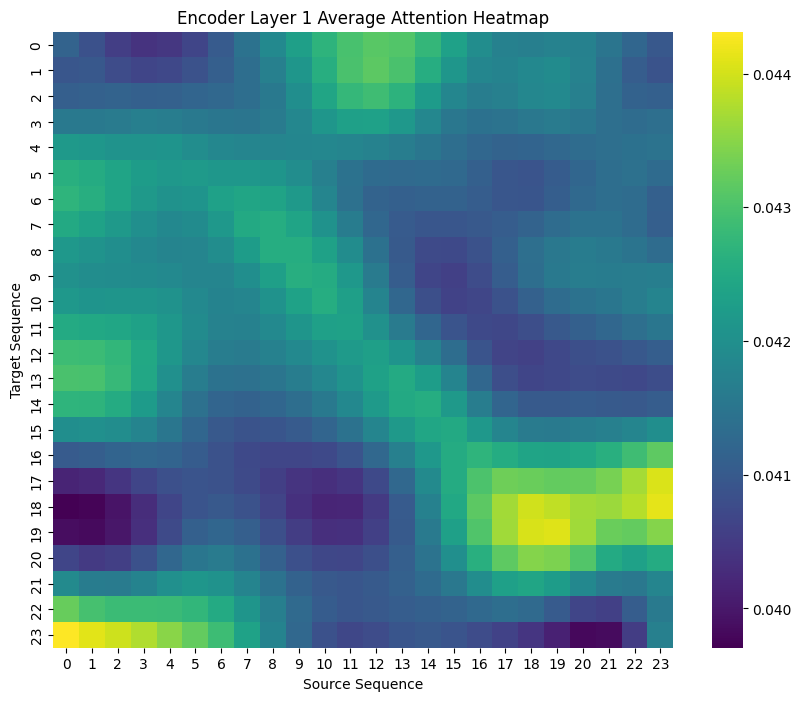

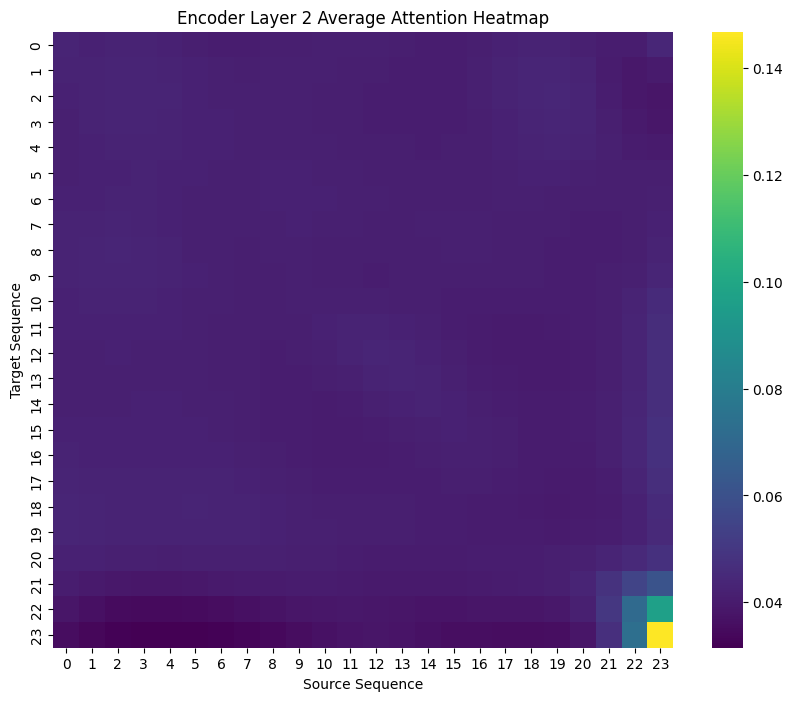

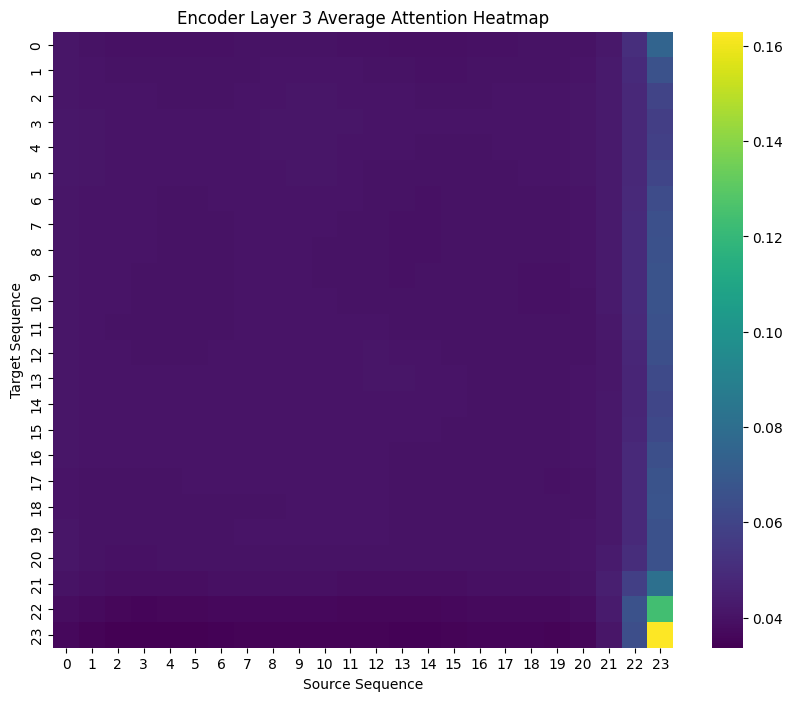

In [40]:
for layer, attention_tensor in enumerate(attention_outputs.attentions):
    # Reshape the tensor for easier visualization
    attention_array = attention_tensor.cpu().detach().numpy()  # Convert to numpy array
    
    # Take the mean along the specified dimensions
    attention_mean = attention_array.mean(axis=(0, 1))  # Take mean along num_heads and batch_size dimensions
    
    # Plotting the heatmap for the average attention weights
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_mean, cmap='viridis')
    plt.title(f'Encoder Layer {layer+1} Average Attention Heatmap')
    plt.xlabel('Source Sequence')
    plt.ylabel('Target Sequence')
    plt.savefig(f'PatchTST_Modified_{layer+1}.png')
    plt.show()

In [50]:
# Inverse transform predictions to original scale
#all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))
#print(all_predictions)
#print(all_predictions.shape)

all_prediction = []
for item in all_predictions:
    all_prediction.append(item[0].item())
all_prediction = np.array(all_prediction)
#print(y_val)
true_values = val[-len(all_prediction):]
#print(true_values.shape)
#print(all_prediction.shape)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_values, all_prediction))
mae = mean_absolute_error(true_values, all_prediction)
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 3.679312420071913
Mean Absolute Error (MAE): 2.478994520063753


In [51]:
all_prediction.shape

(1728,)

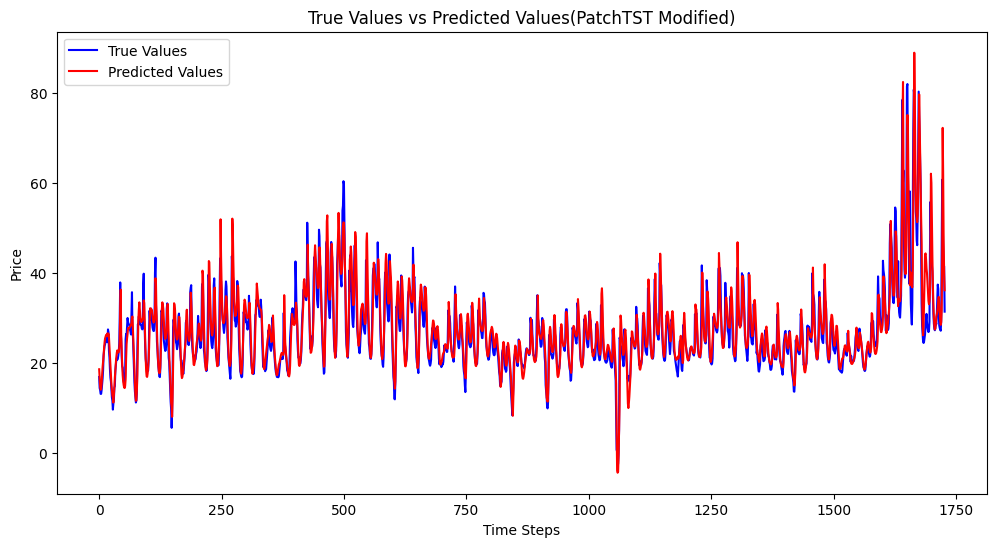

In [52]:
# Plot true values vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(true_values, label='True Values', color='blue')
plt.plot(all_prediction, label='Predicted Values', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('True Values vs Predicted Values(PatchTST Modified)')
plt.legend()
plt.savefig('PatchTST_modified.png')
plt.show()
